Pylbm for solids.

Pylbm is a python-package for numerical simulations using the Lattice-Boltzmann-Method (LBM). For more general information, refer to the website https://pylbm.readthedocs.io/en/latest/, this documentation will focus on the scope of the project, which is to extend and use pylbm to solve equations of quasi-static linear elasticity in 2D. 

This document gives a very short introduction/tutorial to get started with pylbm.

## 1. Overview

Pylbm is fairly simple to use: a simulation can be created by defining a dictionary which contains all relevant data (geometry, scheme, ...), creating a `pylbm.Simulation` object and then running the simulation for a number of time steps with the `pylbm.Simulation.one_time_step()` method:
    
```python
import pylbm

dico = {...}

sim = pylbm.Simulation(dico)

for i in range(N_Time_Steps):
    sim.one_time_step()
```
        
When performing a single time step, pylbm will, in this order, compute:
    
    Boundary Conditions
    Transport
    Transform Distributions to Moments (F2M)
    1/2 Source Term
    Relaxation
    1/2 Source Term
    Transform Moments to Distributions (M2F)

## 2. Dictionary

The dictionary contains all infos regarding the problem we want to solve, the domain, the discretization etc. Let's start building a dictionary:
First we will define the geometry. For this we have to define a `'box'` which is a rectangle that contains the entire domain. For this box we can set the size in x and y-direction and label the edges. The labels will be important to specify boundary conditions. Complex geometries can be defined with `'elements'`, which we will see later. Next we can choose a space-step dx using the key `'space_step'` and the lattice speed with `'scheme_velocity'`. Note that the size of the box should be a multiple of dx and that the time step dt is not given explicitely but computed from the scheme velocity (=dx/dt). Below is a simple example. We can visualize the geometry by creating a `pylbm.Geometry` object.


/cluster/home/bucphili/testenv/lib64/python3.10/site-packages/pylbm/viewer/matplotlib_viewer.py:483: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  self.ax.grid(visible, which=which, alpha=alpha)


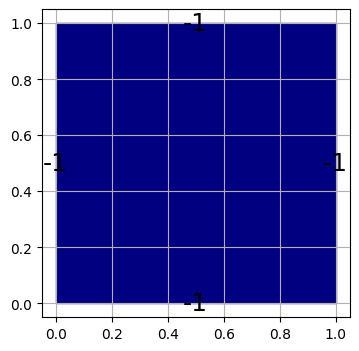

In [7]:
import pylbm
dico = {
    'box' : {'x': [0,1], 'y': [0,1], 'label': -1},
    'space_step': 0.1,
    'scheme_velocity': 1.
}
geom = pylbm.Geometry(dico)
geom.visualize(viewlabel = True)

Next, we define a scheme. Here we can specify the velocity-set, moment matrix, equilibrium moments, relaxation parameters, conserved moments and optionally source-terms. We will use the D2Q8-stencil and can specify the velocities with their usual labels:
        
        0: (0, 0)
        1: (1, 0)
        2: (0, 1)
        3: (-1, 0)
        4: (0, -1)
        5: (1, 1)
        6: (-1, 1)
        7: (-1, -1)
        8: (1, -1)
This can be written compactly as
```python
'velocities': list(range(1,9))
```
Note that we start the range at 1 since we exclude the (0,0)-population. 

The `'M'` key is used to define a matrix M which transforms populations $f = [f_{10}, f_{01}, f_{-10},...]$ to moments as $m = M*f$. The moments m are labeled as $m = [m_{10}, m_{01}, m_{11}, m_{s}, m_{d}, m_{12}, m_{21}, m_{f}]$ and the relaxation parameters and equilibrium moments should be provided in this order. 

Now we can also set the conserved moments which are not relaxed towards an equilibrium. For our purposes, $m_{10}$ and $m_{01}$ are identified with the displacement field, our primary solution quantity. We can define sympy symbols for the conserved moments which will be used to refer to these quantities, in our case we will use u for the x-displacement and v for the y-displacement. Sidenote: Almost all parameters in the dictionary can and should be provided as sympy symbols, since pylbm does most of the precomputations in symbolic expressions.  

Below is an example where we extend our dictionary to include the scheme (equilibrium moments, M, and relaxation parameters are already set such that this scheme would solve for the displacement field for quasi-static linear elasticity). 

In [8]:
import sympy as sp

#define symbols
u, v = sp.symbols('u, v')
THETA, MU_ND, K_ND, GAMMA = sp.symbols('THETA, MU_ND, K_ND, GAMMA')

#moment matrix
M = sp.Matrix([[1,0,-1,0,1,-1,-1,1],[0,1,0,-1,1,1,-1,-1],[0,0,0,0,1,-1,1,-1],[1,1,1,1,2,2,2,2],
    [1,-1,1,-1,0,0,0,0],[0,0,0,0,1,-1,-1,1],[0,0,0,0,1,1,-1,-1],[GAMMA,GAMMA,GAMMA,GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA]])

#equilibrium moments in order
Meq = [u,v,0,0,0,THETA*u,THETA*v,0]

#relaxation parameters
w10 = 0.
w01 = 0.
w11 = 1/(MU_ND/THETA+.5)
ws = 1/(2*K_ND/(1+THETA)+.5)
wd = 1/(2*MU_ND/(1-THETA)+.5)
w12 = 1.5
w21 = 1.5
wf = 1.
omega = [w10,w01,w11,ws,wd,w12,w21,wf]

dico = {
    'box' : {'x': [0,1], 'y': [0,1], 'label': -1},
    'space_step': 0.1,
    'scheme_velocity': 1.,
    'schemes':[
            {
                'velocities': list(range(1,9)),
                'conserved_moments': [u,v],
                'M': M,
                'equilibrium': Meq,
                'relaxation_parameters': omega,
                'source_terms': {u: 0., v: 0.}
                }]
    }

Now we almost have everything ready to create a simulation. To finish our dictionary we have to include an initial condition, a generator and specify the pylbm-algorithm. For initial conditions we can define functions and use the `'init'` key. For the generator we will use cython. Pylbm generates code for the actual computations and can generate either numpy, loo.py or cython code. For this project I always used cython, and cannot guarantee if it works with the other options. The algorithms provided are called Base-Algorithm which computes a time-step in the order explained above, and Pull-Algorithm which combines Transport and F2M into a single function. Similarly, I always used Base-Algorithm and don't know if Pull-Algorithm works properly with the extensions I implemented.

Finally we define the material parameters and include all numerical parameters with the key `'parameters'` so pylbm can relate the symbols to actual numerical values. Below is the complete dictionary. Note that I transformed material parameters and geometry to lattice units.

In [4]:
import sympy as sp
import pylbm

#geometry
dx = 0.1
dt = 0.1
la = dx/dt
L_box = 1.

#characteristic dimensions
U = 1.
L = dx
T = dt

#geometry in lattice units
dx_nd = dx/L
L_box_nd = L_box/L
la_nd = 1.

#material parameters (actual values and in lattice units)
E = 0.1/0.1731
E_nd = T/(L*L)*E
nu = .7
K = E/(2*(1-nu))
K_nd = K*T/L**2
mu = E/(2*(1+nu))
mu_nd = mu*T/L**2
theta = 1/3

#define symbols
u, v, LA = sp.symbols('u, v, LA')
THETA, MU_ND, K_ND, GAMMA = sp.symbols('THETA, MU_ND, K_ND, GAMMA')

#moment matrix
M = sp.Matrix([[1,0,-1,0,1,-1,-1,1],[0,1,0,-1,1,1,-1,-1],[0,0,0,0,1,-1,1,-1],[1,1,1,1,2,2,2,2],
    [1,-1,1,-1,0,0,0,0],[0,0,0,0,1,-1,-1,1],[0,0,0,0,1,1,-1,-1],[GAMMA,GAMMA,GAMMA,GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA,1+2*GAMMA]])

#equilibrium moments in order
Meq = [u,v,0,0,0,THETA*u,THETA*v,0]

#relaxation parameters
w10 = 0.
w01 = 0.
w11 = 1/(MU_ND/THETA+.5)
ws = 1/(2*K_ND/(1+THETA)+.5)
wd = 1/(2*MU_ND/(1-THETA)+.5)
w12 = 1.5
w21 = 1.5
wf = 1.
omega = [w10,w01,w11,ws,wd,w12,w21,wf]
gamma = theta*.5/((1+theta)*((1/ws-.5).evalf(subs={K_ND:K_nd,THETA:theta})-.5))

#initial condition
def u_init(x,y):
    return 0.

def v_init(x,y):
    return 0.

dico = {
    'box' : {'x': [0,L_box_nd], 'y': [0,L_box_nd], 'label': -1},
    'space_step': dx_nd,
    'scheme_velocity': LA,
    'parameters': {LA: la_nd,
            THETA: theta,
            MU_ND: mu_nd,
            K_ND: K_nd,
            GAMMA: gamma,
            },
    'init': {u: u_init, v: v_init},
    'generator': 'cython',
    'lbm_algorithm': {'name': pylbm.algorithm.BaseAlgorithm},
    'schemes':[
            {
                'velocities': list(range(1,9)),
                'conserved_moments': [u,v],
                'M': M,
                'equilibrium': Meq,
                'relaxation_parameters': omega,
                'source_terms': {u: 0., v: 0.}
                }]
    }

With this dictionary we can create a simulation and run it for 100 time steps.  

In [5]:
sim = pylbm.Simulation(dico)
for i in range(100):
    sim.one_time_step()

## 3. Extracting Results and Other Information

### 3.1 Solution quantities

The computed moments and populations can be accessed from the simulation object: 

        sim.m[i]
        sim.m_halo[i]
        sim.f[i]
        sim.f_halo[i]
for the i-th moment/population (in the order we saw above, e.g. $m[0]=m_{10}=u$; for conserved moments we can also use `sim.m[u]` and `sim.m[v]`). These quantities are stored in 2D-Arrays the size of the grid and are in post-collision state. When creating the domain of the simulation, pylbm generates a layer of ghost nodes around the bounding box, called halo. These nodes are used for handling of the boundary conditions. `sim.m[i]` returns the moment i for all nodes inside the domain, while `sim.m_halo[i]` includes the ghost nodes as well.

### 3.2 Domain information

For plotting results, computing error norms etc. it is also useful to get domain information:

        sim.nt: current time step
        sim.t: current time (increments in dt)
        sim.domain.x: vector of x-coordinates of the lattice inside the domain
        sim.domain.x_halo: vector of x-coordinates of the lattice including ghost nodes
        sim.domain.y / sim.domain.y_halo: similar
        sim.domain.coords[i] / sim.domain.coords_halo[i]: general method to get coordinate vectors (e.g. i = 0 gives x coordinates)
        sim.domain.visualize(): show a plot of the domain
        sim.domain.in_or_out: 2D-array the size of the lattie including ghost nodes with a flag for each node, indicating if the node is inside the domain or outside
        sim.domain.valin: value of the flag for inside nodes (standard vaue set to 999)
        sim.domain.valout: value of the flag for outside nodes (standard value set to -1)
Let's get some information about our simulation:    



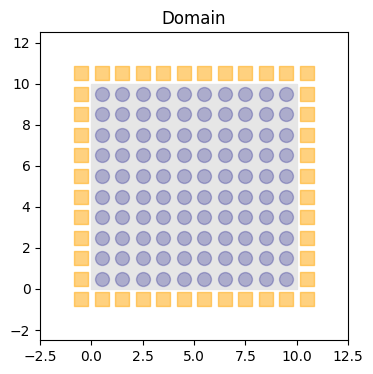

In [12]:
sim.domain.visualize()

The grey square is the bounding box inside which all the domain nodes lie, plotted as blue circles. The ghost nodes are marked as orange squares. Remember that we scaled everything to lattice units, where the grid spacing dx is exactly 1. Since we defined the physical length of the box as 1 and the physical space step as 0.1, the box in lattice units is scaled to a side legth of 10, with 10 nodes inside the domain in each direction. When defining a domain in this fashion the boundary (the edge of the grey square) will always be placed at one half of the grid spacing. Therefore the first node in the lower left corner has coordinates $(0.5,0.5)$ 

In [26]:
print('sim.x =', sim.domain.x, ', sim.x.size =', sim.domain.x.size)
print('sim.x_halo =', sim.domain.x_halo, ', sim.x_halo.size =', sim.domain.x_halo.size)

sim.x = [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5] , sim.x.size = 10
sim.x_halo = [-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5] , sim.x_halo.size = 12


As we can see these quantities have different shapes so we have to be careful when extracting results and choose if need the array including or excluding the layer of ghost nodes. `sim.m[i][j,k]` stores the value of $m_{i}$ for the node with coordinates `sim.x[j]` and `sim.y[k]`, while `sim.m_halo[i][j,k]` holds the value of $m_{i}$ for the node with coordinates `sim.x_halo[j]` and `sim.y_halo[k]`.

In [28]:
print('sim.m[0] =')
print(sim.m[0])
print('sim.m[0].shape =', sim.m[0].shape)

sim.m[0] =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
sim.m[0].shape = (10, 10)


In [29]:
print('sim.m_halo[0] =')
print(sim.m_halo[0])
print('sim.m_halo[0].shape =', sim.m_halo[0].shape)

sim.m_halo[0] =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
sim.m_halo[0].shape = (12, 12)


For more complicated geometries and when using MPI (where every process only sees a part of the entire domain), the most straight forward to extract quantities from inside the domain is to create a mask using `sim.domain.in_or_out` (which returns an array for every node, including ghost nodes, containing a flag if the node is inside or outside the domain). 

In [31]:
print('sim.domain.in_or_out =')
print(sim.domain.in_or_out)
print('sim.domain.in_or_out.shape =', sim.domain.in_or_out.shape)

sim.domain.in_or_out =
[[ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1. 999. 999. 999. 999. 999. 999. 999. 999. 999. 999.  -1.]
 [ -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.]]
sim.domain.in_or_out.shape = (12, 12)


In [33]:
mask_in = sim.domain.in_or_out == sim.domain.valin
print(mask_in)

[[False False False False False False False False False False False False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False  True  True  True  True  True  True  True  True  True  True False]
 [False False False False False False False False False False False False]]


With this mask we can extract quantities from inside the domain, e.g. `sim.m_halo[0][mask_in]`. Note that we have to use 'halo-quantities' since the mask is defined over the entire domain including ghost nodes.  